# Platform for Live Crypto Trading with ML

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/sats4u/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import json
import sys
import pandas as pd
import numpy as np
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb


# settings for reproducible results
#os.environ['CUDA_VISIBLE_DEVICES'] = ''
np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)

In [4]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')

In [5]:
secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'
secrets_filename = secret_data_folder+'data.json'

In [6]:
crypto = lc.CryptoData(asset_details,data_folder)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i')
crypto.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')

In [7]:
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)

In [8]:
ldata_df = crypto.load_cryptos(tickers,save = False)                             

All caught up..!
size of dataset: (167783, 8)


In [9]:
ldata_df

,timestamp,OpenBitcoin,HighBitcoin,LowBitcoin,CloseBitcoin,VolumeBitcoin,CountBitcoin,Date,Future Date
timestamp,,,,,,,,,
1502942400,1502942400,4261.48,4280.56,4261.48,4261.48,2.189061,9.0,2017-08-17 04:01:00,2017-08-17 04:15:00
1502943300,1502943300,4261.48,4270.41,4261.32,4261.45,9.119865,40.0,2017-08-17 04:16:00,2017-08-17 04:30:00
1502944200,1502944200,4280.00,4310.07,4267.99,4310.07,21.923552,58.0,2017-08-17 04:31:00,2017-08-17 04:45:00
1502945100,1502945100,4310.07,4313.62,4291.37,4308.83,13.948531,64.0,2017-08-17 04:46:00,2017-08-17 05:00:00
1502946000,1502946000,4308.83,4328.69,4304.31,4304.31,5.101153,44.0,2017-08-17 05:01:00,2017-08-17 05:15:00
...,...,...,...,...,...,...,...,...,...
1654443900,1654443900,29885.62,29981.00,29873.08,29972.22,504.126520,9090.0,2022-06-05 15:46:00,2022-06-05 16:00:00
1654444800,1654444800,29972.23,30189.00,29932.35,30045.89,1813.333950,23403.0,2022-06-05 16:01:00,2022-06-05 16:15:00
1654445700,1654445700,30045.88,30083.41,29826.96,29853.99,699.977280,14150.0,2022-06-05 16:16:00,2022-06-05 16:30:00


#  "Wick Candles"

---

# Data Exploration


In [10]:
can_btc = fb.Candles(ldata_df,"Bitcoin")
can_btc.candles

,Low,High,Open,Close,Volume
Date,,,,,
2017-08-17 04:01:00,4261.48,4280.56,4261.48,4261.48,2.189061
2017-08-17 04:16:00,4261.32,4270.41,4261.48,4261.45,9.119865
2017-08-17 04:31:00,4267.99,4310.07,4280.00,4310.07,21.923552
2017-08-17 04:46:00,4291.37,4313.62,4310.07,4308.83,13.948531
2017-08-17 05:01:00,4304.31,4328.69,4308.83,4304.31,5.101153
...,...,...,...,...,...
2022-06-05 15:46:00,29873.08,29981.00,29885.62,29972.22,504.126520
2022-06-05 16:01:00,29932.35,30189.00,29972.23,30045.89,1813.333950
2022-06-05 16:16:00,29826.96,30083.41,30045.88,29853.99,699.977280


In [11]:
can_btc.candles

,Low,High,Open,Close,Volume
Date,,,,,
2017-08-17 04:01:00,4261.48,4280.56,4261.48,4261.48,2.189061
2017-08-17 04:16:00,4261.32,4270.41,4261.48,4261.45,9.119865
2017-08-17 04:31:00,4267.99,4310.07,4280.00,4310.07,21.923552
2017-08-17 04:46:00,4291.37,4313.62,4310.07,4308.83,13.948531
2017-08-17 05:01:00,4304.31,4328.69,4308.83,4304.31,5.101153
...,...,...,...,...,...
2022-06-05 15:46:00,29873.08,29981.00,29885.62,29972.22,504.126520
2022-06-05 16:01:00,29932.35,30189.00,29972.23,30045.89,1813.333950
2022-06-05 16:16:00,29826.96,30083.41,30045.88,29853.99,699.977280


In [13]:
can_btc.candles

,Close,vol_diff
Date,,
2017-08-17 06:31:00,4345.45,-0.006737
2017-08-17 06:46:00,4324.35,-3.324938
2017-08-17 07:01:00,4316.62,-0.167697
2017-08-17 07:16:00,4291.38,0.037377
2017-08-17 07:31:00,4300.00,0.679983
...,...,...
2022-06-05 15:46:00,29972.22,-8.575250
2022-06-05 16:01:00,30045.89,1309.207430
2022-06-05 16:16:00,29853.99,-1113.356670


In [12]:
can_btc.buildfeatures()
can_btc.ta_fullplot()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


KeyError: ignored

In [ ]:
can_btc

In [ ]:
can_btc.candles.isna().sum()

In [ ]:
can_btc.normedcandles()
can_btc.candles_norm

# Generate timeseries
## Normalize data

In [ ]:
can_btc.getlaststeps(steps=-60000)
can_btc.gettimeseries(candle_timestep=crypto.kline_size)

In [ ]:
x_candles= can_btc.x_candles
x_time=can_btc.x_time
y = can_btc.y

In [35]:
scaler = MinMaxScaler(feature_range=(0.2, 0.8))

# candles=candles.iloc[10:]
# candles.fillna(method="pad",inplace=True)
# candles_norm = scaler.fit_transform(candles)

# print(candles.iloc[0])
# print('  ------')
# print(candles_norm[0])

## Remove NaNs
due to Bolliger Bands and moving averages

In [ ]:
# candles_norm = candles_norm[10:]
# TEST=False
# if not TEST:
#     RECENT_DATA = 60000
#     candles_norm = candles_norm[-RECENT_DATA:]
#     print(len(candles_norm))


60000


## Generate dataset based on timeseries

In [ ]:
# x_candles = []
# x_time = []
# y = []

# step_back = 48

# for i in range(len(candles_norm) - step_back):
#     example_candles = []
#     example_time = []

#     if (TEST or crypto.kline_size=="1h" or crypto.kline_size=="15m"):
#         for o in range(0, step_back):
#             example_candles.append(candles_norm[i + o])
#             t = candles.iloc[10 + i + o].name
#             example_time.append([t.hour / 24, t.weekday() / 7])
#     elif(crypto.kline_size=="1m"):
#         for o in range(0, step_back):
#             example_candles.append(candles_norm[i + o])
#             t = candles.iloc[10 + i + o].name
#             example_time.append([t.minute / 60., t.hour/24])  

#     x_candles.append(example_candles)
#     x_time.append(example_time)
#     y.append(candles_norm[i+step_back][3])

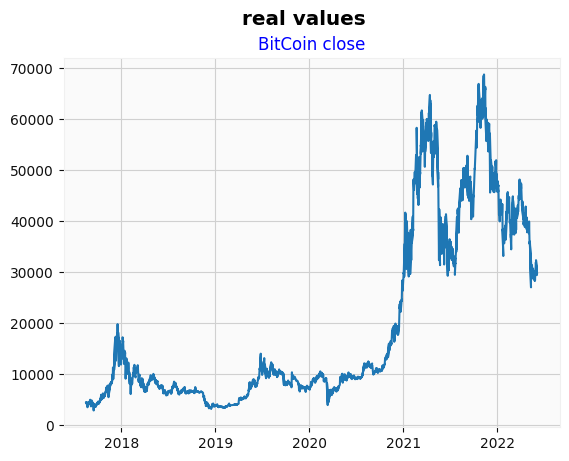

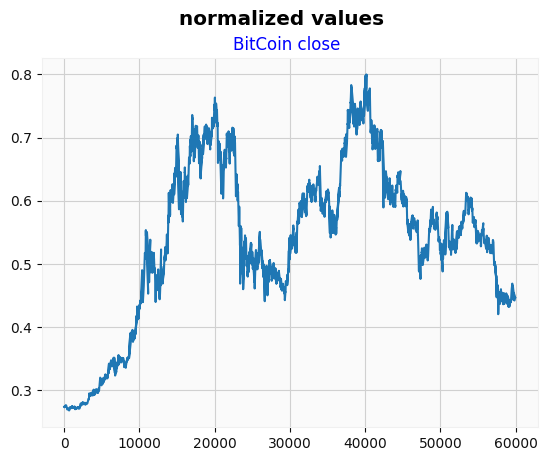

In [ ]:
# plt.plot(candles['Close'])
# plt.title('BitCoin close', fontdict={
#     'fontsize': 12,
#     'fontweight': 1,
#     'color': 'blue',
#     'verticalalignment': 'baseline',
#     'horizontalalignment': 'center'
# })
# plt.suptitle('real values')
# plt.show()

# plt.plot(y)
# plt.title('BitCoin close ', fontdict={
#     'fontsize': 12,
#     'fontweight': 1,
#     'color': 'blue',
#     'verticalalignment': 'baseline',
#     'horizontalalignment': 'center'
# })
# plt.suptitle('normalized values')
# plt.show()

In [21]:
np.shape(x_candles)
candles = can_btc.candles
step_back=48

### Create training and validation datasets

In [22]:
split_point = int(len(x_candles) * 0.9)

x_train_candles = np.asarray(x_candles[:split_point], dtype=np.float32)
x_train_time = np.asarray(x_time[:split_point], dtype=np.float32)
y_train = np.asarray(y[:split_point], dtype=np.float32)

x_test_candles = np.asarray(x_candles[split_point:], dtype=np.float32)
x_test_time = np.asarray(x_time[split_point:], dtype=np.float32)
y_test = np.asarray(y[split_point:], dtype=np.float32)

In [23]:
print(x_train_candles.shape)
print(x_train_time.shape)
print(y_train.shape)
print('from', candles.iloc[0].name, 'to', candles.iloc[split_point + step_back].name)

print('   --------')

print(x_test_candles.shape)
print(x_test_time.shape)
print(y_test.shape)
print('from', candles.iloc[split_point + step_back + 1].name, 'to', candles.iloc[-step_back].name)

(53956, 48, 9)
(53956, 48, 2)
(53956,)
from 2017-08-17 06:31:00 to 2019-03-05 20:46:00
   --------
(5996, 48, 9)
(5996, 48, 2)
(5996,)
from 2019-03-05 21:01:00 to 2022-06-05 04:01:00


## Implement predictive model
---

#### Use the"Swish" activation function

In [24]:
def swish(x):
    return keras.backend.sigmoid(x) * x

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Candles (InputLayer)           [(None, 48, 9)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 48, 32)       896         ['Candles[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 48, 32)       2048        ['Candles[0][0]']                
                                                                                                  
 conv1d_4 (Conv1D)              (None, 48, 32)       3776        ['Candles[0][0]']                
                                                                                              

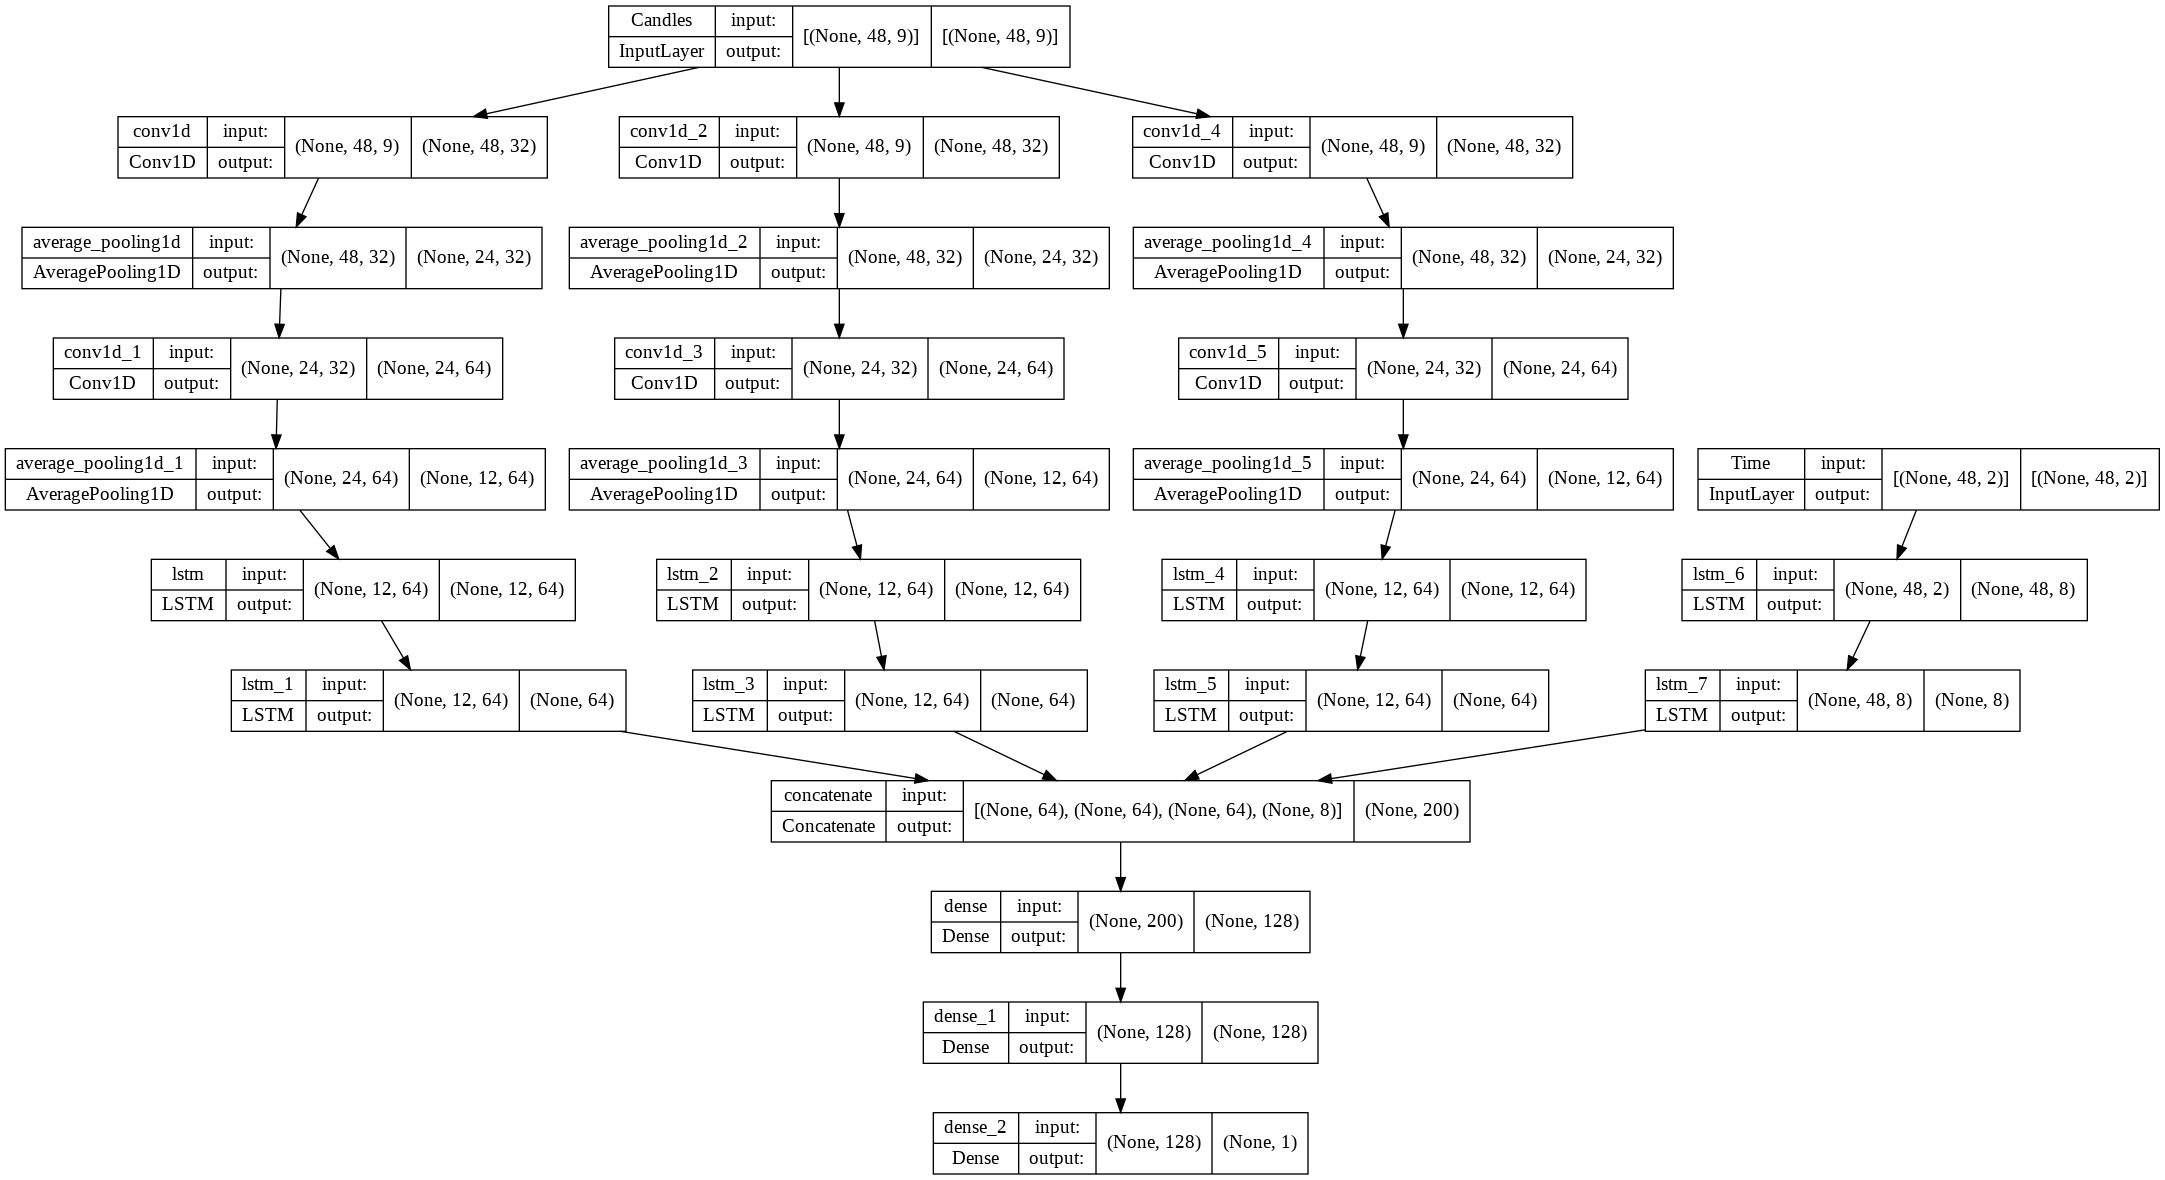

In [25]:
def get_conv_lstm_block(input, kernel_size_1, kernel_size_2):
    conv_1 = keras.layers.Conv1D(
        filters=32,
        kernel_size=kernel_size_1,
        activation=keras.activations.swish,
        padding='same'
    )(input)
    average_1 = keras.layers.AveragePooling1D()(conv_1)
    
    conv_2 = keras.layers.Conv1D(
        filters=64,
        kernel_size=kernel_size_2,
        activation=keras.activations.swish,
        padding='same'
    )(average_1)
    average_2 = keras.layers.AveragePooling1D()(conv_2)
    
    lstm_1 = keras.layers.LSTM(units=64, return_sequences=True)(average_2)
    lstm_2 = keras.layers.LSTM(units=64)(lstm_1)
    
    return lstm_2


input_candles = keras.Input(shape=(x_train_candles.shape[1], x_train_candles.shape[2]), name='Candles')
input_time = keras.Input(shape=(x_train_time.shape[1], x_train_time.shape[2]), name='Time')

conv_1 = get_conv_lstm_block(input_candles, kernel_size_1=3, kernel_size_2=3)
conv_2 = get_conv_lstm_block(input_candles, kernel_size_1=7, kernel_size_2=7)
conv_3 = get_conv_lstm_block(input_candles, kernel_size_1=13, kernel_size_2=13)

lstm_time_1 = keras.layers.LSTM(units=8, return_sequences=True)(input_time)
lstm_time_2 = keras.layers.LSTM(units=8)(lstm_time_1)

conc = keras.layers.Concatenate(axis=-1)([conv_1, conv_2, conv_3, lstm_time_2])

dense_1 = keras.layers.Dense(units=128, activation=keras.activations.swish)(conc)
dense_2 = keras.layers.Dense(units=128, activation=keras.activations.swish)(dense_1)

output = keras.layers.Dense(units=1, activation=keras.activations.linear)(dense_2)

model = keras.Model(inputs=[input_candles, input_time], outputs=output)

model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.mean_absolute_error)

model.summary()
keras.utils.plot_model(model, "conv_lstm_net.png", show_shapes=True)

In [26]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights/weights',
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True
)

history = model.fit(
    [x_train_candles, x_train_time],
    y_train,
    epochs=20,
    batch_size=4096,
    validation_data=(
        [x_test_candles, x_test_time],
        y_test
    ),
    callbacks=model_checkpoint_callback
)

model.load_weights('weights/weights')

Epoch 1/20
14/14 [==============================] - 31s 371ms/step - loss: 0.1773 - val_loss: 0.0426
Epoch 2/20
14/14 [==============================] - 1s 96ms/step - loss: 0.0495 - val_loss: 0.0192
Epoch 3/20
14/14 [==============================] - 1s 94ms/step - loss: 0.0209 - val_loss: 0.0202
Epoch 4/20
14/14 [==============================] - 1s 85ms/step - loss: 0.0240 - val_loss: 0.0163
Epoch 5/20
14/14 [==============================] - 1s 84ms/step - loss: 0.0299 - val_loss: 0.0345
Epoch 6/20
14/14 [==============================] - 1s 93ms/step - loss: 0.0205 - val_loss: 0.0131
Epoch 7/20
14/14 [==============================] - 1s 96ms/step - loss: 0.0152 - val_loss: 0.0212
Epoch 8/20
14/14 [==============================] - 1s 93ms/step - loss: 0.0147 - val_loss: 0.0087
Epoch 9/20
14/14 [==============================] - 1s 94ms/step - loss: 0.0145 - val_loss: 0.0084
Epoch 10/20
14/14 [==============================] - 1s 96ms/step - loss: 0.0126 - val_loss: 0.0188
Epoch 1

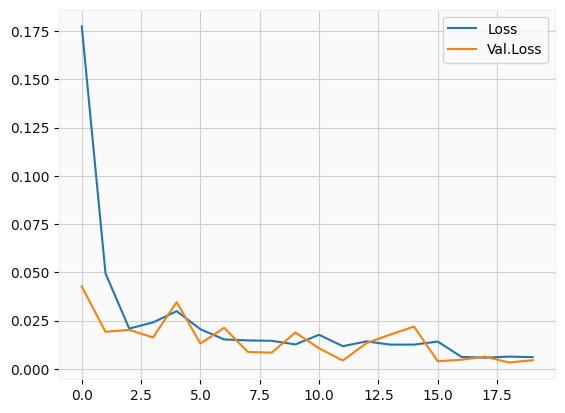

In [27]:

plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

### Utilizzo e validazione del modello predittivo

In [28]:
preds = model.predict([x_test_candles, x_test_time], batch_size=4096)

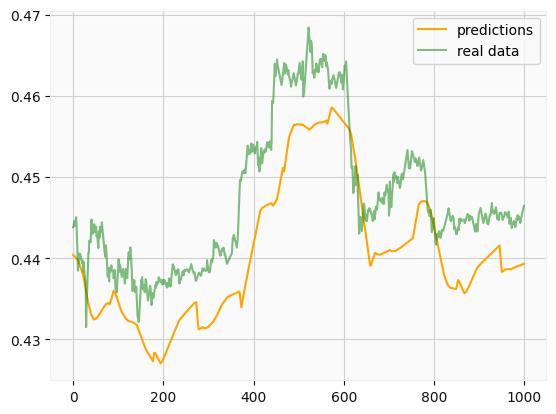

In [29]:
plt.plot(preds[-1000:], color='orange', label='predictions')
plt.plot(y_test[-1000:], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

In [30]:
def log_return(series, periods=1):
    log_ret = np.log(series).diff(periods=periods)
    if periods < 0:
        log_ret*= -1.
    return log_ret

In [31]:
df_pred_exp = pd.DataFrame(np.array([np.squeeze(preds),np.squeeze(y_test)]).T,columns=["Predicted","Expected"])

df_pred_exp["Return Expected"] = log_return(df_pred_exp["Expected"],periods=-1)
df_pred_exp["Return Predicted"] = log_return(df_pred_exp["Predicted"],periods=-1)


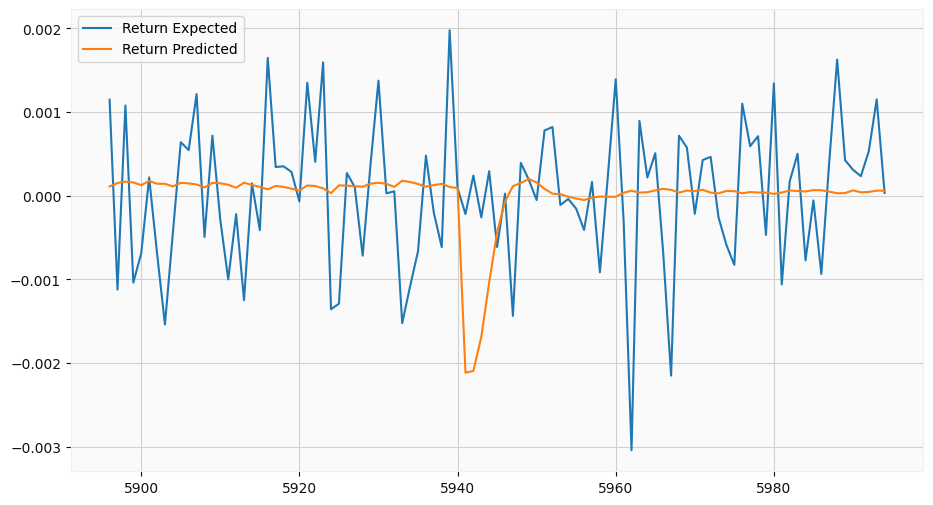

In [32]:
f, axs = plt.subplots( figsize=(11, 6))
df_pred_exp.iloc[-100:].plot(y="Return Expected",ax=axs)
df_pred_exp.iloc[-100:].plot(y="Return Predicted",ax=axs)

In [52]:
len(can_btc.candles_norm[0])
can_btc.candles

,Low,High,Open,Close,Volume,UpperBB,LowerBB,price2volratio,vol_diff
Date,,,,,,,,,
2017-08-17 06:31:00,4319.83,4345.45,4328.65,4345.45,3.494176,4354.619977,4264.944023,4.808001,-0.006737
2017-08-17 06:46:00,4324.35,4345.45,4345.45,4324.35,0.169238,4345.916804,4286.227196,-124.676491,-3.324938
2017-08-17 07:01:00,4316.62,4316.62,4316.62,4316.62,0.001541,4346.272361,4287.181639,0.000000,-0.167697
2017-08-17 07:16:00,4291.38,4291.38,4291.38,4291.38,0.038918,4348.406850,4281.557150,0.000000,0.037377
2017-08-17 07:31:00,4291.39,4300.00,4291.39,4300.00,0.718901,4348.690957,4280.411043,11.976614,0.679983
...,...,...,...,...,...,...,...,...,...
2022-06-05 14:46:00,29752.87,29837.86,29776.51,29791.71,286.305150,29809.313016,29637.404984,0.053090,115.637360
2022-06-05 15:01:00,29781.70,29829.65,29791.72,29803.15,223.742310,29831.428763,29633.997237,0.051086,-62.562840
2022-06-05 15:16:00,29788.39,29879.00,29803.15,29829.20,330.354340,29858.883772,29628.784228,0.078855,106.612030


In [33]:
def denorm(value):
    example = [0.5 for x in range(9)]
    example[3] = value
    return scaler.inverse_transform([example])[0][3]

In [36]:
def backtesting(fee=0.025):
    wallet = 0
    total_wallet_history = []
    single_wallet_history = []

    buys_cnt = 0
    buys_cnt_win = 0
    buys_cnt_losses = 0
    drawback = 0
    old_profit_negative = False
    old_profits = 0

    for i in range(split_point, len(x_candles)):
        prediction = preds[i - split_point][0]
        predicted_close = denorm(prediction)
        previous_close = denorm(candles_norm[i][3])
        real_next_close = denorm(candles_norm[i+1][3])

        if (previous_close + (previous_close * fee)) < predicted_close:  # buy
            profit = real_next_close - previous_close
            if profit > 0:
                profit = profit - (profit * fee)
                buys_cnt_win += 1
                old_profit_negative = False
            else:
                profit = profit + (profit * fee)
                buys_cnt_losses += 1
                if old_profit_negative:
                    old_profits += profit
                else:
                    old_profits = profit
                if old_profits < drawback:
                    drawback = old_profits
                old_profit_negative = True
            wallet += profit
            total_wallet_history.append(wallet)
            single_wallet_history.append(profit)
            buys_cnt += 1
        else:
            old_profit_negative = False
            old_profits = 0

    print('Fee:', fee)
    print('----------------------')
    print('Buy     ', buys_cnt, '(', buys_cnt_win, 'ok', buys_cnt_losses, 'ko )')
    print('No-op   ', (len(x_candles) - split_point) - buys_cnt)
    print('Wallet  ', wallet)
    print('Drawback', drawback)

    return total_wallet_history, single_wallet_history, wallet

total_wallet_history, single_wallet_history, wallet = backtesting(fee=0.025)

NotFittedError: ignored

Total earned 3782.9209999999875


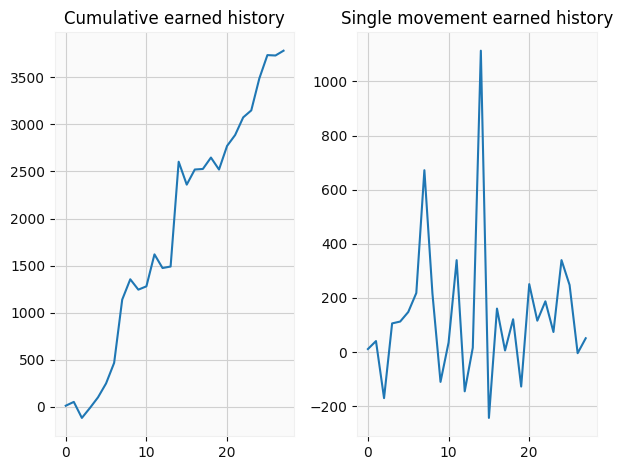

In [ ]:
print('Total earned', wallet)

plt.subplot(1, 2, 1)
plt.plot(total_wallet_history)
plt.title('Cumulative earned history')

plt.subplot(1, 2, 2)
plt.plot(single_wallet_history)
plt.title('Single movement earned history')

plt.tight_layout()
plt.show()

## training on more epochs

In [37]:
preds_old = preds
y_test_old = y_test

In [38]:
many_epochs = 50
print(f'training on {many_epochs} epochs...')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights/weights',
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True
)

history = model.fit(
    [x_train_candles, x_train_time], 
    y_train, 
    epochs=many_epochs,
    initial_epoch=21, 
    batch_size=4096,
    validation_data=([x_test_candles, x_test_time], y_test),
    callbacks=model_checkpoint_callback,
    verbose=1
)

training on 50 epochs...
Epoch 22/50
14/14 [==============================] - 1s 98ms/step - loss: 0.0063 - val_loss: 0.0031
Epoch 23/50
14/14 [==============================] - 1s 95ms/step - loss: 0.0061 - val_loss: 0.0062
Epoch 24/50
14/14 [==============================] - 1s 84ms/step - loss: 0.0066 - val_loss: 0.0046
Epoch 25/50
14/14 [==============================] - 1s 85ms/step - loss: 0.0065 - val_loss: 0.0080
Epoch 26/50
14/14 [==============================] - 1s 85ms/step - loss: 0.0067 - val_loss: 0.0064
Epoch 27/50
14/14 [==============================] - 1s 85ms/step - loss: 0.0066 - val_loss: 0.0056
Epoch 28/50
14/14 [==============================] - 1s 84ms/step - loss: 0.0066 - val_loss: 0.0064
Epoch 29/50
14/14 [==============================] - 1s 84ms/step - loss: 0.0067 - val_loss: 0.0074
Epoch 30/50
14/14 [==============================] - 1s 84ms/step - loss: 0.0066 - val_loss: 0.0068
Epoch 31/50
14/14 [==============================] - 1s 85ms/step - loss: 0

In [39]:
model.load_weights('weights/weights')

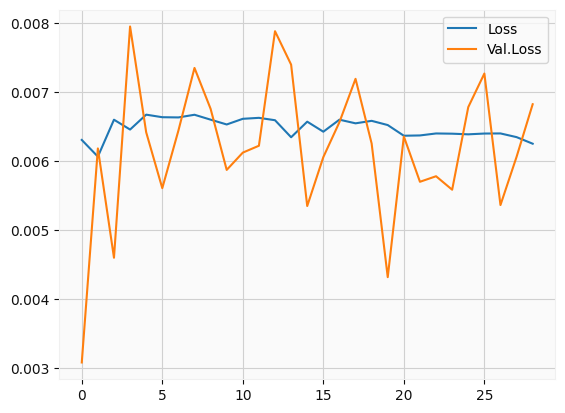

In [40]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

In [41]:
preds = model.predict([x_test_candles, x_test_time], batch_size=4096)

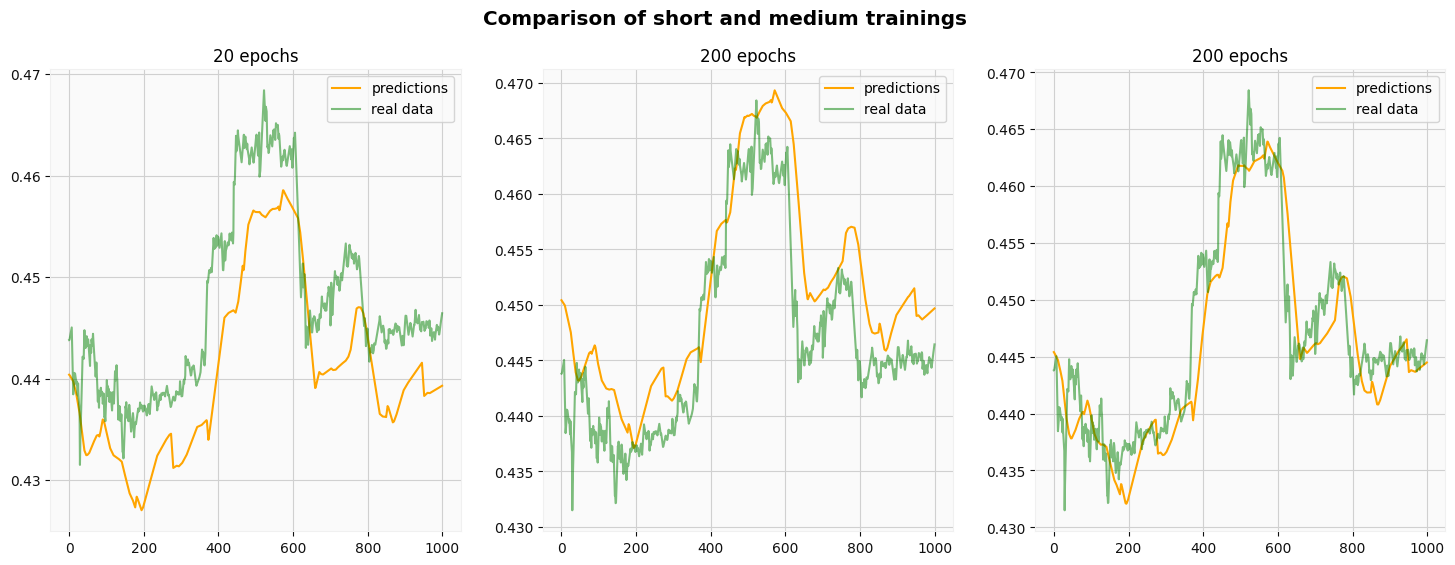

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(18, 6)
fig.suptitle('Comparison of short and medium trainings')

ax1.set_title('20 epochs')
ax1.plot(preds_old[-1000:], color='orange', label='predictions')
ax1.plot(y_test_old[-1000:], color='green', alpha=0.5, label='real data')
ax1.legend()

ax2.set_title('200 epochs')
ax2.plot(preds[-1000:], color='orange', label='predictions')
ax2.plot(y_test[-1000:], color='green', alpha=0.5, label='real data')
ax2.legend()

ax3.set_title('200 epochs')
ax3.plot((preds[-1000:]+preds_old[-1000:])/2, color='orange', label='predictions')
ax3.plot(y_test[-1000:], color='green', alpha=0.5, label='real data')
ax3.legend()


plt.show()

In [ ]:
df_pred_exp = pd.DataFrame(np.array([np.squeeze(preds),np.squeeze(y_test)]).T,columns=["Predicted","Expected"])

df_pred_exp["Return Expected"] = log_return(df_pred_exp["Expected"],periods=-1)
df_pred_exp["Return Predicted"] = log_return(df_pred_exp["Predicted"],periods=-1)


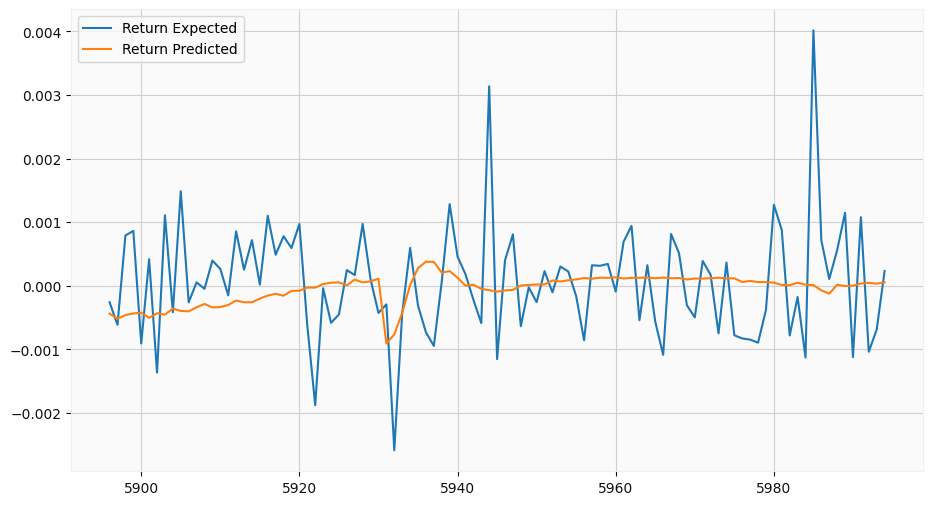

In [ ]:
f, axs = plt.subplots( figsize=(11, 6))
df_pred_exp.iloc[-100:].plot(y="Return Expected",ax=axs)
df_pred_exp.iloc[-100:].plot(y="Return Predicted",ax=axs)

In [ ]:
total_wallet_history, single_wallet_history, wallet = backtesting(fee=0.025)

Fee: 0.025
----------------------
Buy      203 ( 134 ok 69 ko )
No-op    5793
Wallet   11698.86549999998
Drawback -604.422000000004


Total earned 11698.86549999998


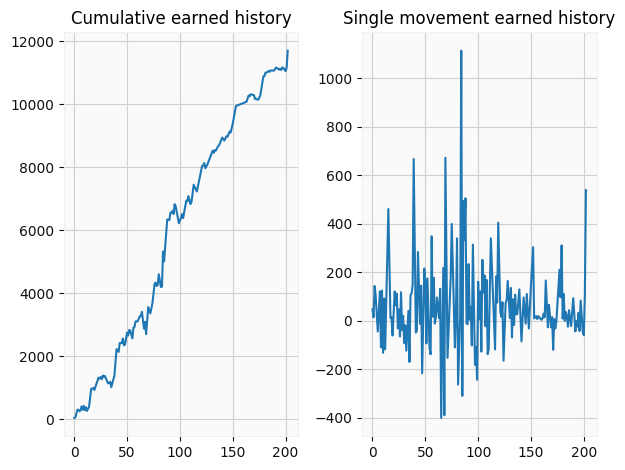

In [ ]:
print('Total earned', wallet)

plt.subplot(1, 2, 1)
plt.plot(total_wallet_history)
plt.title('Cumulative earned history')

plt.subplot(1, 2, 2)
plt.plot(single_wallet_history)
plt.title('Single movement earned history')

plt.tight_layout()
plt.show()